In [ ]:
!pip install pytorch-tabnet
!unzip -q /content/drive/MyDrive/Project/Dacon/lgauto/open.zip
# !pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
replace meta/x_feature_info.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import random
from tqdm import tqdm

import pandas as pd
pd.set_option('max_columns', 100)
import numpy as np

import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from pytorch_tabnet.metrics import Metric


import torch
import torch.nn as nn
# import pytorch_lightning as pl

from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
class Config:
  seed = 42
  dir_path = './'

In [ ]:
def seed_everything(args):
  random.seed(args)
  np.random.seed(args)
  os.environ["PYTHONHASHSEED"] = str(args)
  torch.manual_seed(args)
  torch.cuda.manual_seed(args) 
  torch.backends.cudnn.deterministic = True 
  torch.backends.cudnn.benchmark = False  


In [ ]:
group_dict = {
    "Group_1" : ["X_01", "X_02", "X_05", "X_06"],
    "Group_2" : ["X_03", "X_10", "X_11"],
    "Group_3" : ["X_04", "X_23", "X_47", "X_48"],
    "Group_4" : ["X_07", "X_08", "X_09"],
    "Group_5" : ["X_12"],
    "Group_6" : ["X_13"],
    "Group_7" : ["X_14", "X_15", "X_16", "X_17", "X_18"],
    "Group_8" : ["X_19", "X_20", "X_21", "X_22"],
    "Group_9" : ["X_24", "X_25", "X_26", "X_27", "X_28", "X_29"],
    "Group_10" : ["X_30", "X_31", "X_32", "X_33"],
    "Group_11" : ["X_34", "X_35", "X_36", "X_37"],
    "Group_12" : ["X_38", "X_39", "X_40"],
    "Group_13" : ["X_41", "X_42", "X_43", "X_44"],
    "Group_14" : ["X_45"],
    "Group_15" : ["X_46"],
    "Group_16" : ["X_49"],
    "Group_17" : ["X_50", "X_51", "X_52", "X_53", "X_54", "X_55", "X_56"],
}

In [ ]:
def dataset_split_X_y(df):    
  df.drop('ID', axis=1, inplace=True)
  # df = df.astype({'X_04':'category'})
  # df = df.astype({'X_23':'category'})
  # df = df.astype({'X_47':'category'})
  # df = df.astype({'X_48':'category'})

  features = df.filter(regex='X') # Input : X Feature
  targets = df.filter(regex='Y') # Output : Y Feature
  
  return features, targets

def is_category(features):
  cols = features.columns
  #cat = ['X_04', 'X_23', 'X_47', 'X_48']
  is_category = [col for col in cols if features[col].dtypes != 'category']
  
  return is_category


def create_category_columns(features):

  category = is_category(features)

  scaler = MaxAbsScaler()
  features[category] = scaler.fit_transform(features[category])

  # for col in category:
  #   gap = features[col].max() - features[col].min()
  #   add_col = pd.qcut(features[col], q = 50 ,duplicates="drop")
  #   features[col + '_category'] = add_col

  return features

# def stage_mean(features, group_dict):
#   for col in group_dict:
#     features['Mean_'+ col] = features[group_dict[col]].mean(axis=1)

#   return features

def create_idx_dims(features):
  categorical_columns = []
  categorical_dims =  {}

  for col in tqdm(features.columns, desc='Converting...'):
    if features[col].dtypes == 'category':
      le = LabelEncoder()
      features[col] = le.fit_transform(features[col].values)
      categorical_columns.append(col)
      categorical_dims[col] = len(le.classes_)

  cat_idxs = [i for i,f in enumerate(features.columns.to_list()) if f in categorical_columns]
  cat_dims = [categorical_dims[f] for i,f in enumerate(features.columns.to_list()) if f in categorical_columns]

  return features, cat_idxs, cat_dims

df = pd.read_csv('./train.csv')
features, targets = dataset_split_X_y(df)
features = create_category_columns(features)
#features = stage_mean(features, group_dict)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
test = pd.read_csv('./test.csv')
test_features, test_targets = dataset_split_X_y(test)
test_features = create_category_columns(test_features)
#test_features = stage_mean(test_features, group_dict)

In [ ]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [ ]:
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

In [ ]:
train

In [ ]:
tabnet_params = dict(
    n_d = 64,
    n_a = 64,
    n_steps = 3,
    gamma = 1.3,
    n_independent = 3,
    n_shared = 3,
    lambda_sparse = 0,
    optimizer_fn = Adam,
    optimizer_params = dict(lr = (2e-2), weight_decay = 1e-5),
    mask_type = "entmax",
    scheduler_params = dict(T_0 = 10, T_mult = 2, eta_max = 0.1, T_up = 5, gamma = 0.3),
    scheduler_fn = CosineAnnealingWarmUpRestarts,
    seed = Config.seed,
    verbose = 10
)


kfold = KFold(n_splits = 7, random_state = 42, shuffle = True)


oof_predictions = np.zeros((39608, 14))
test_predictions = np.zeros((39608, 14))
feature_importances = pd.DataFrame()
feature_importances["feature"] = features.columns.tolist()
stats = pd.DataFrame()
explain_matrices = []
masks_ =[]

for fold, (trn_ind, val_ind) in enumerate(kfold.split(features)):
  print('##################################################')
  print(f'\t\tTraining fold {fold + 1}\t\t')
  print('##################################################')
  X_train, X_val = features.iloc[trn_ind].values, features.iloc[val_ind].values
  y_train, y_val = targets.iloc[trn_ind].values, targets.iloc[val_ind].values

  
  clf =  TabNetRegressor(**tabnet_params)

  clf.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric = ['mse'],
    loss_fn = nn.MSELoss(),
    max_epochs = 1000,
    patience = 150,
    batch_size = 1024, 
    virtual_batch_size = 128,
    num_workers = 4,
    drop_last = False,
                      )
                              
  saved_filepath = clf.save_model(f'./fold_{fold + 1}')
  explain_matrix, masks = clf.explain(X_val)
  explain_matrices.append(explain_matrix)
  masks_.append(masks[0])
  masks_.append(masks[1])

  oof_predictions[val_ind] = clf.predict(X_val)
  test_predictions+=clf.predict(test_features.values)/7
  feature_importances[f"importance_fold{fold}"] = clf.feature_importances_  

##################################################
		Training fold 1		
##################################################
Device used : cuda
epoch 0  | loss: 29.71864| val_0_mse: 1.86048 |  0:00:03s
epoch 10 | loss: 1.77676 | val_0_mse: 1.71346 |  0:00:33s
epoch 20 | loss: 1.56678 | val_0_mse: 1.67847 |  0:01:03s
epoch 30 | loss: 1.49615 | val_0_mse: 1.45739 |  0:01:33s
epoch 40 | loss: 1.55035 | val_0_mse: 1.54319 |  0:02:03s
epoch 50 | loss: 1.77268 | val_0_mse: 2.11533 |  0:02:33s
epoch 60 | loss: 1.48973 | val_0_mse: 1.44106 |  0:03:03s
epoch 70 | loss: 1.49251 | val_0_mse: 1.4499  |  0:03:32s
epoch 80 | loss: 1.5934  | val_0_mse: 1.8444  |  0:04:02s
epoch 90 | loss: 1.74822 | val_0_mse: 2.88901 |  0:04:32s
epoch 100| loss: 1.46214 | val_0_mse: 1.43237 |  0:05:01s
epoch 110| loss: 1.45228 | val_0_mse: 1.43448 |  0:05:31s
epoch 120| loss: 1.45078 | val_0_mse: 1.44495 |  0:06:01s
epoch 130| loss: 1.4469  | val_0_mse: 1.45034 |  0:06:30s
epoch 140| loss: 1.45609 | val_0_mse: 1.52766 |

In [ ]:
sub = pd.read_csv('./sample_submission.csv')
sub.shape

(39608, 15)

In [ ]:
sub

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TEST_00002,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TEST_00003,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,TEST_00004,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,TEST_00005,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,TEST_39604,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39604,TEST_39605,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39605,TEST_39606,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39606,TEST_39607,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(test_predictions)

39608

In [ ]:
sub = pd.read_csv('./sample_submission.csv')
sub.shape
sub.iloc[:,1:] = test_predictions
sub.to_csv('/content/drive/MyDrive/tmp.csv', index=False)

In [ ]:
feature_importances

,feature,importance_fold0,importance_fold1,importance_fold2,importance_fold3,importance_fold4,importance_fold5,importance_fold6
0,X_01,0.228607,0.000000,6.537027e-03,0.0,0.0,0.000000,0.000000
1,X_02,0.000000,0.162904,9.244784e-02,0.0,0.0,0.000000,0.000000
2,X_03,0.000006,0.000000,1.979147e-08,0.0,0.0,0.000000,0.000000
3,X_04,0.000000,0.000000,0.000000e+00,0.0,0.0,0.002561,0.000000
4,X_05,0.000000,0.138662,1.331515e-04,0.0,0.0,0.000000,0.048408
...,...,...,...,...,...,...,...,...
68,Mean_Group_13,0.000000,0.000000,2.516702e-02,0.0,0.0,0.000000,0.000000
69,Mean_Group_14,0.000000,0.000000,5.059785e-05,0.0,0.0,0.000000,0.000000
70,Mean_Group_15,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000,0.000000
71,Mean_Group_16,0.000000,0.000000,0.000000e+00,0.0,0.0,0.000000,0.000000


In [ ]:
feature_importances['mean_importance'] = feature_importances[['importance_fold0','importance_fold1','importance_fold2','importance_fold3','importance_fold4', 'importance_fold5', 'importance_fold6']].mean(axis=1)

In [ ]:
feature_importances.sort_values(by='mean_importance', ascending=False, inplace=True)

In [ ]:
import seaborn as sns
feature_importances

,feature,importance_fold0,importance_fold1,importance_fold2,importance_fold3,importance_fold4,importance_fold5,importance_fold6,mean_importance
30,X_31,0.302747,0.000000,0.000205,0.000000,0.000000,0.129608,0.368581,0.114449
61,Mean_Group_6,0.000000,0.000000,0.000000,0.366031,0.000000,0.000000,0.151291,0.073903
19,X_20,0.000000,0.000000,0.000000,0.101987,0.015194,0.377341,0.000000,0.070646
48,X_49,0.000000,0.377493,0.067618,0.000000,0.000000,0.000000,0.014154,0.065609
63,Mean_Group_8,0.000000,0.000000,0.000000,0.000000,0.315881,0.000000,0.000000,0.045126
...,...,...,...,...,...,...,...,...,...
41,X_42,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,X_16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
44,X_45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46,X_47,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


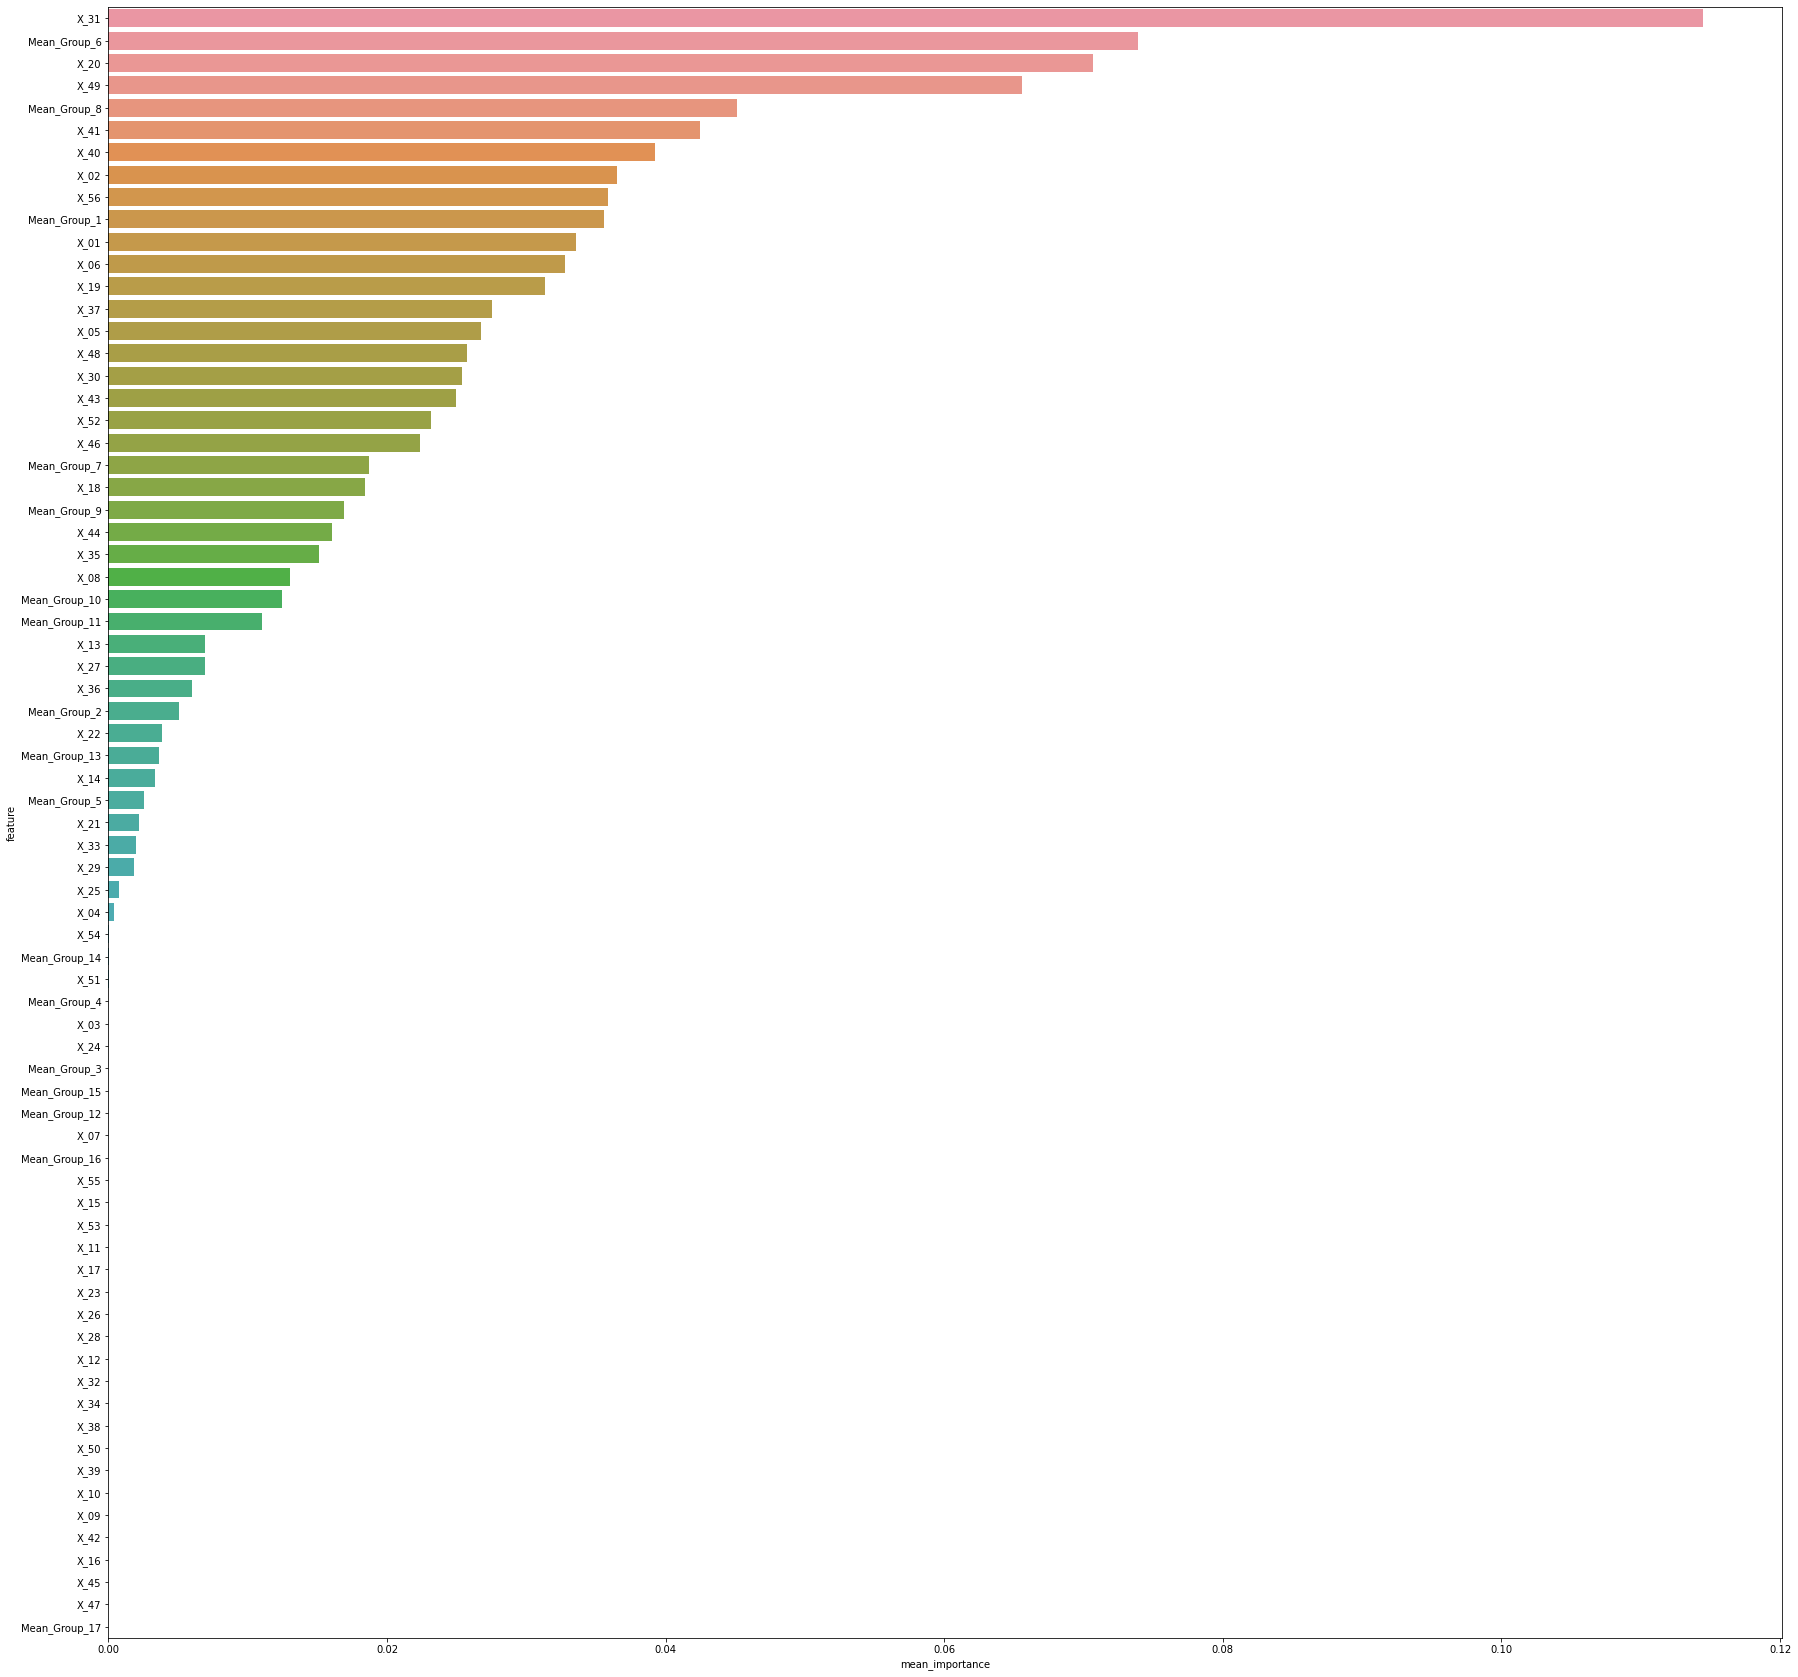

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
sns.barplot(y = feature_importances['feature'], x=feature_importances['mean_importance'])